<a href="https://colab.research.google.com/github/nikmerlock97/SCENICprotocol/blob/master/Nik_pySCENIC_protocol_CLI_PBMC10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pySCENIC protocol: PBMC10k

September 2019

Dataset: *10k PBMCs from a Healthy Donor* available from 10x Genomics ([here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3)).

In [2]:
!pip install scanpy
!pip install loompy
!pip install MulticoreTSNE

     |████████████████████████████████| 10.3MB 6.1MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 133kB 44.5MB/s 
     |████████████████████████████████| 1.2MB 36.7MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=07748d7bf3aa1e2610cf4732f17547c5bf92909169295f223f405944e924dc53
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for sinfo: filename=sinfo-0.3.1-cp37-none-any.whl size=7012 sha256=b671c6daf9f5982e4b57b190e9b42682ac7b74a061f17ff2568bc8e2b0a25956
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=dee0f6aefbb03c47dbcc7d8baf023fbdc06f627362c26a8d50dd043f1393d4a0
  Stored in directory: /root/.cache/pip/wh

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = '/content/drive/MyDrive/pySCENIC'
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "pbmc10k_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'pbmc10k_scenic_integrated-output.loom'

In [9]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
MulticoreTSNE               NA
PIL                         7.1.2
anndata                     0.7.6
astor                       0.8.1
bottleneck                  1.3.2
cffi                        1.14.5
cloudpickle                 1.3.0
cycler                      0.10.0
cython_runtime              NA
dask                        2.12.0
dateutil                    2.8.1
debugpy                     1.0.0
decorator                   4.4.2
get_version                 2.2
google                      NA
h5py                        2.10.0
ipykernel                   4.10.1
ipython_genutils            0.2.0
ipywidgets                  7.6.3
joblib                      1.0.1
kiwisolver                  1.3.1
legacy_api_wrap             1.2
llvmlite                    0.34.0
loompy                      3.0.6
matplotlib                  3.2.2
mpl_toolkits                NA
natsort                     5.5.0
numba                     

In [11]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

## Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

### Reading in expression data: 10x Genomics mtx files

In [15]:
f_mtx_dir = '/content/drive/MyDrive/pySCENIC/mtx/'

adata = sc.read_10x_mtx(
    f_mtx_dir ,                 # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=False) 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


### Reading in expression data: from a text file

In [13]:
f_exprMat = '/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/testruns/pbmc8k/pbmc8k_countMat_filtered.tsv'

adata = sc.read_text( f_exprMat, delimiter='\t', first_column_names=True )

FileNotFoundError: ignored

### write to an unfiltered loom file

Here, we use the loompy functions directly

In [16]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

## Initial/basic filtering

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [19]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [20]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


In [21]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

### Diagnostic plots, pre-filtering

#### Number of genes expressed per cell

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

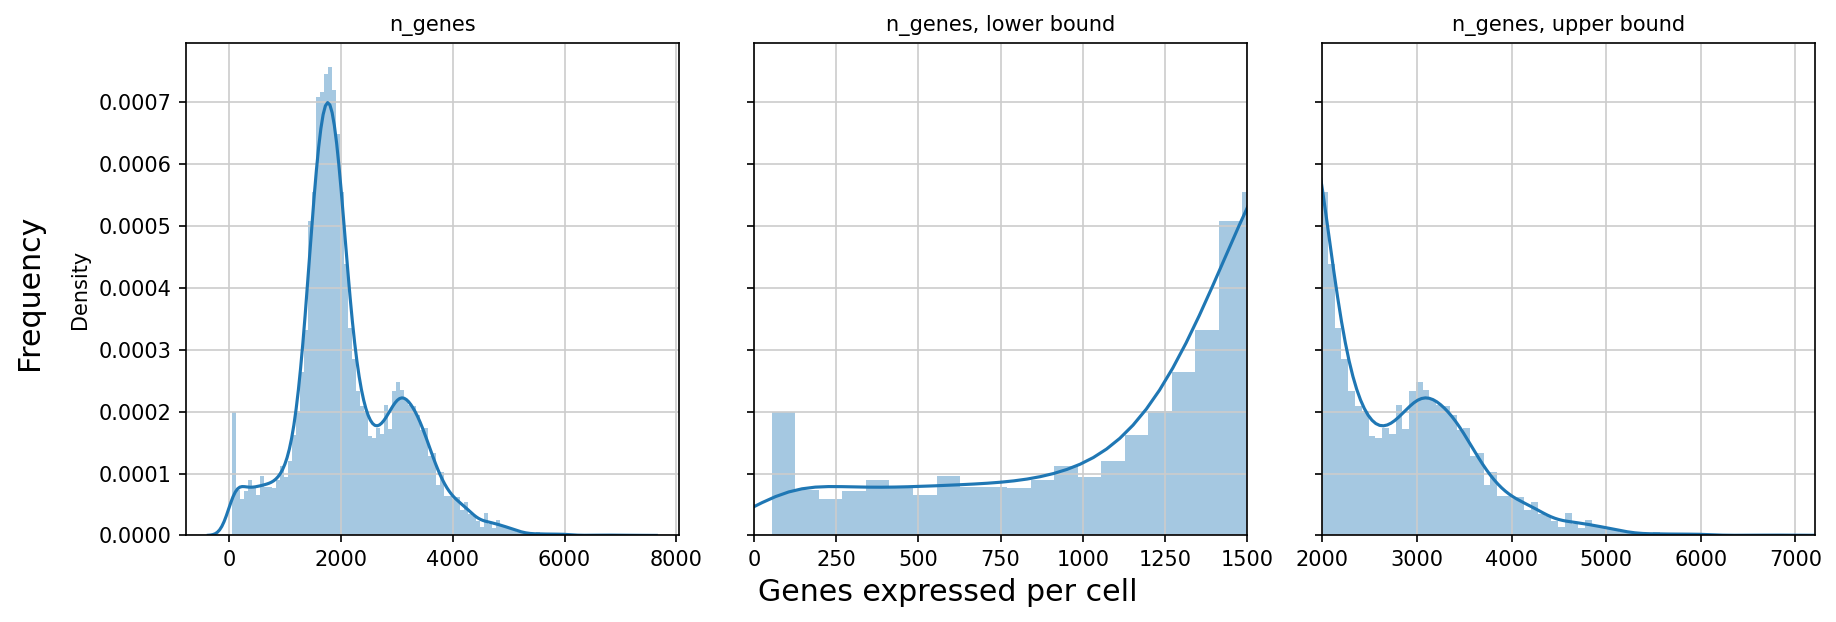

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Percentage of mitochondrial reads per cell

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

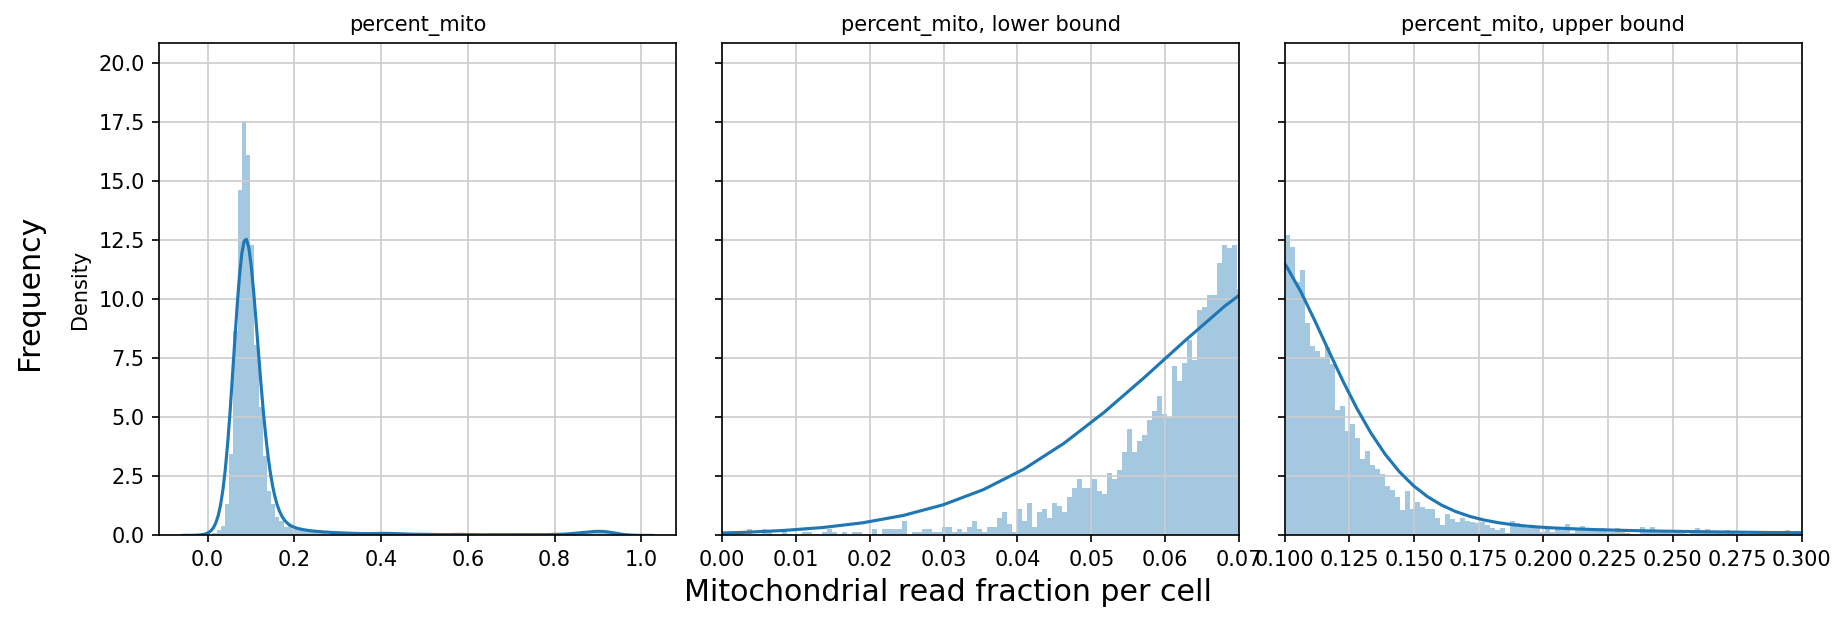

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Three-panel summary plots

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

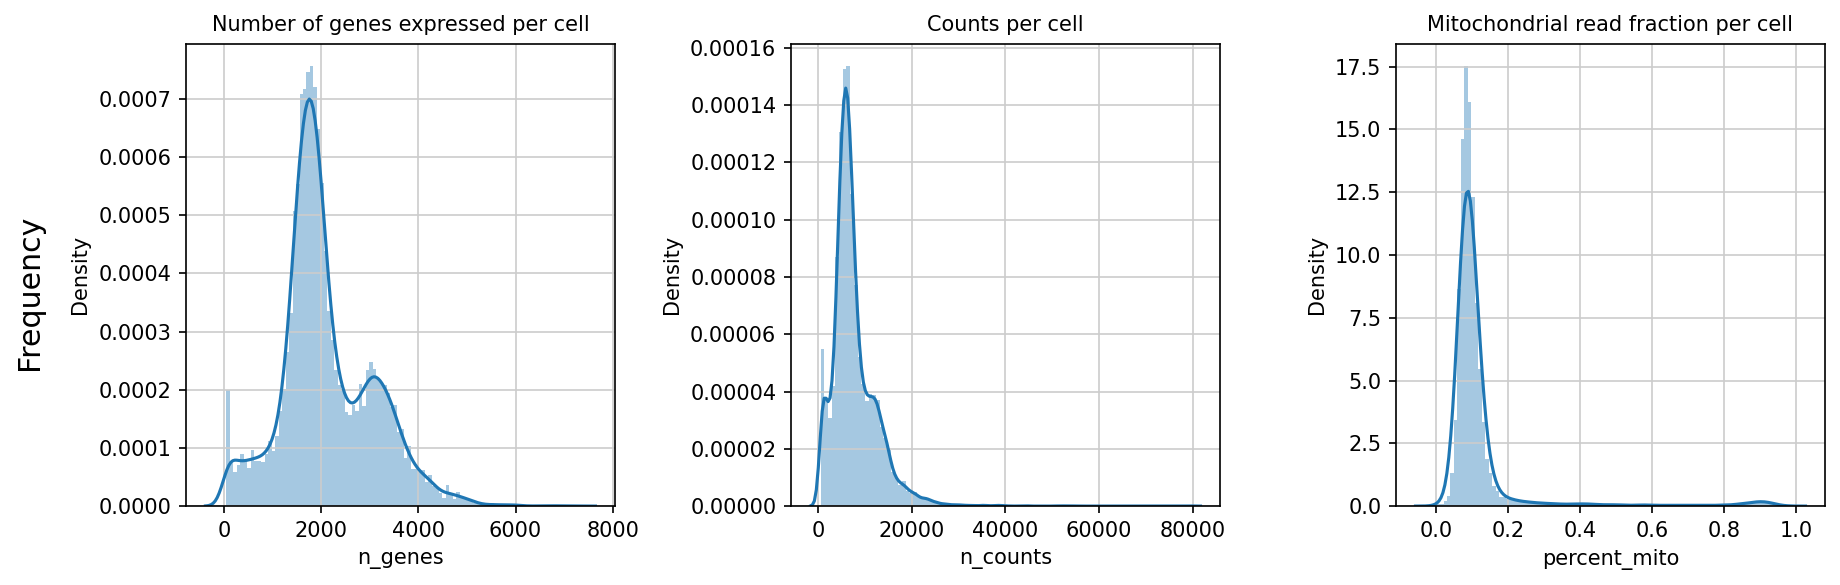

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

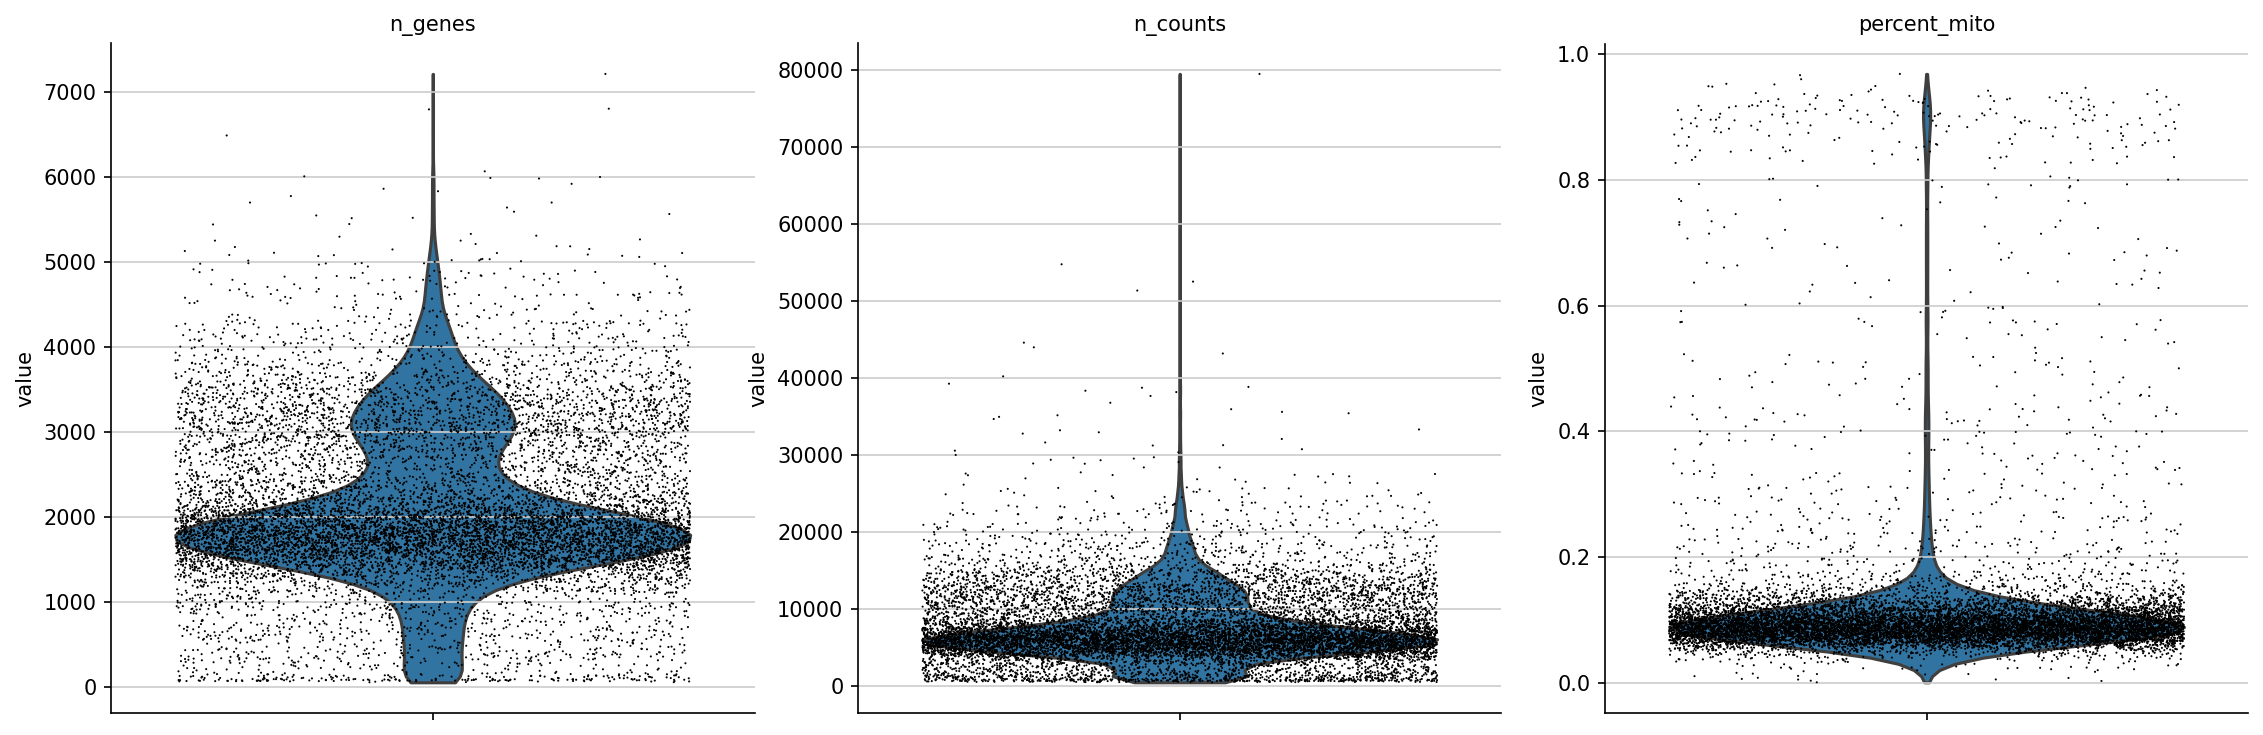

In [25]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

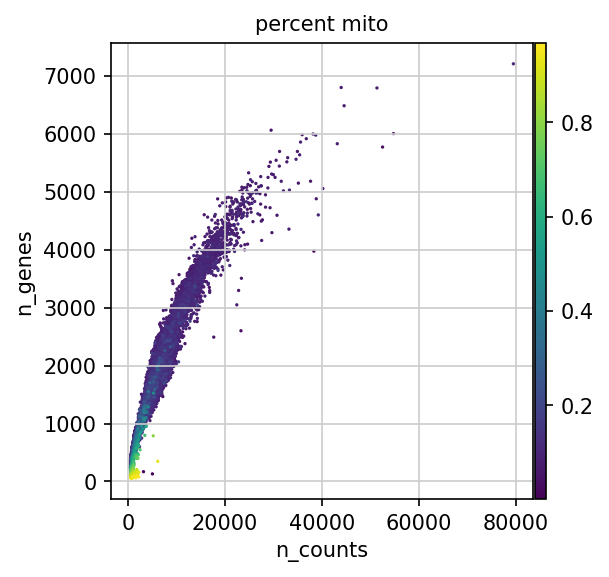

In [26]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Carry out the filtering steps:

In [27]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


In [28]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

### Diagnostic plots, post filtering

#### Three-panel summary plots

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

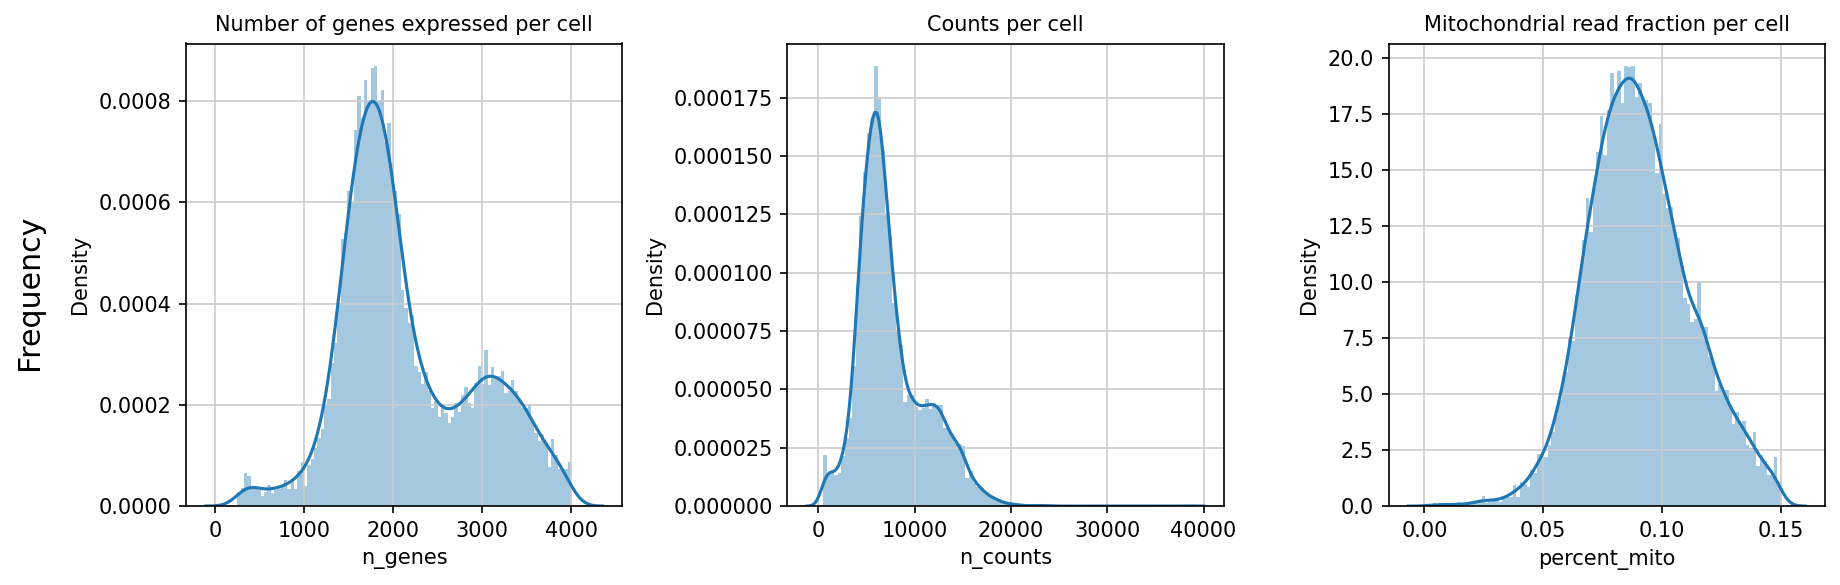

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

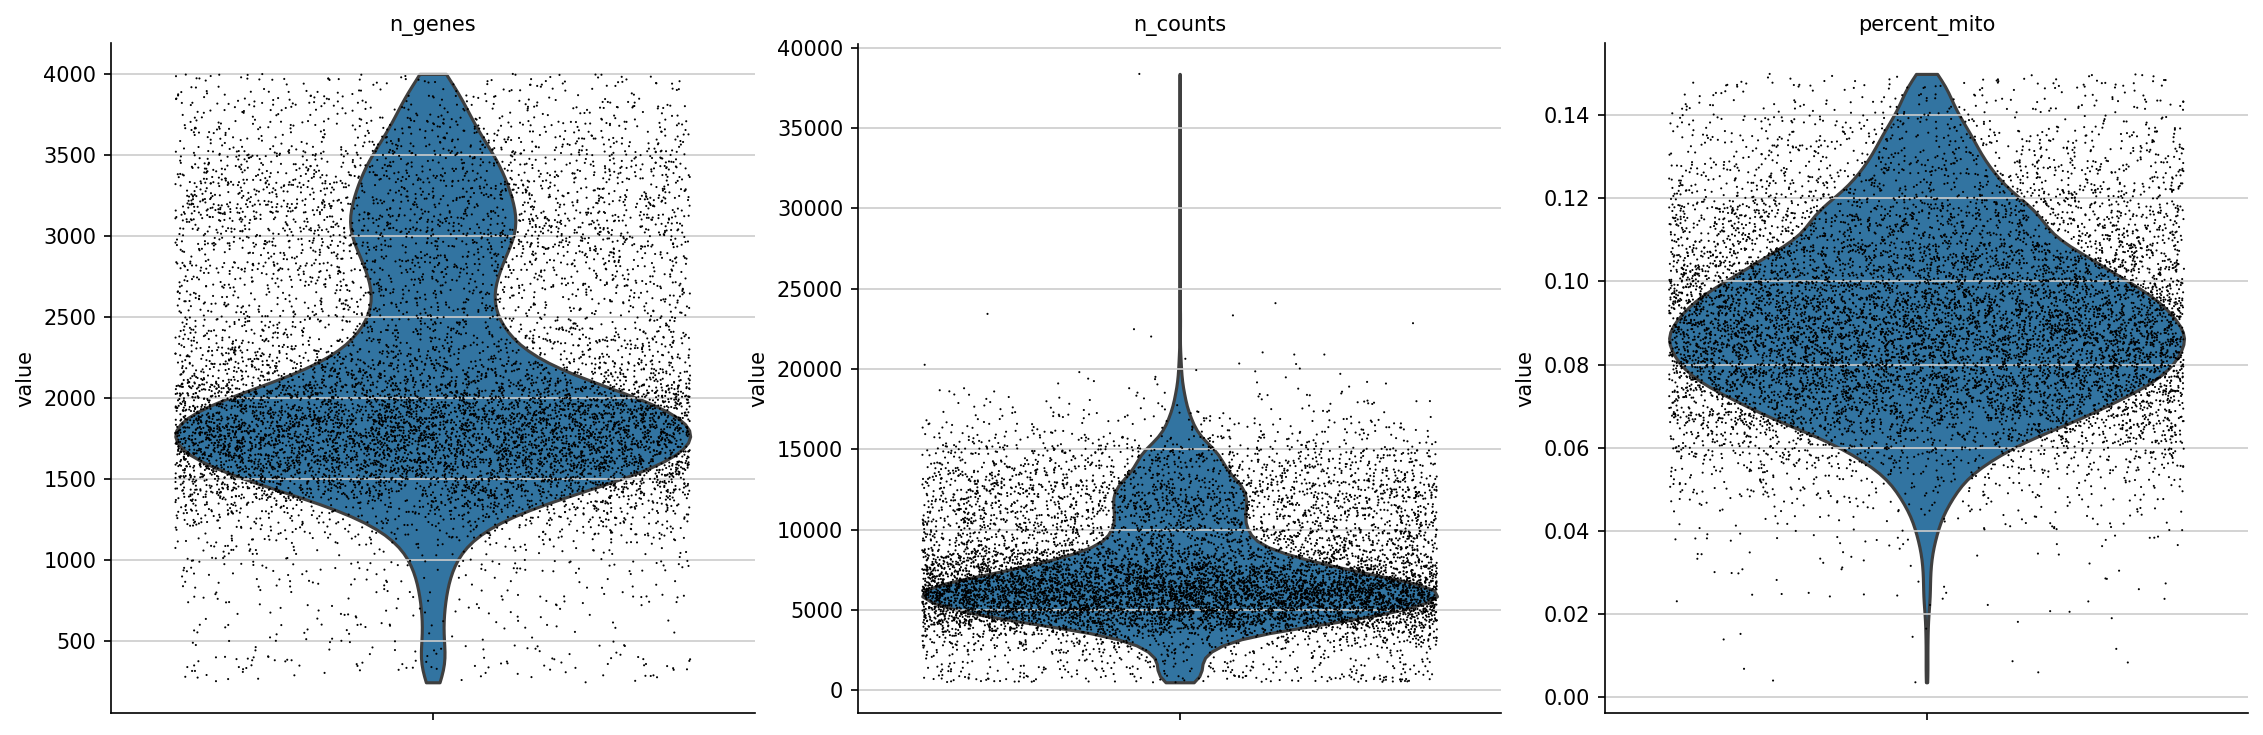

In [30]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

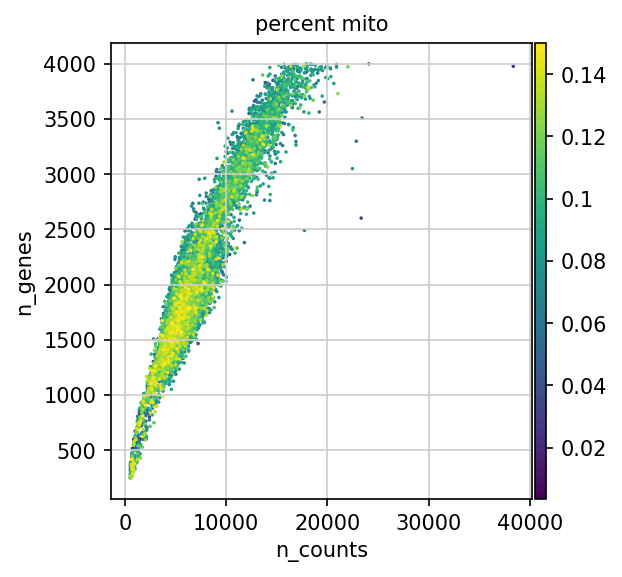

In [31]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Finalize the selected filters

Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [32]:
adata.write( f_anndata_path )

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [33]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

## Further pre-processing of expression data

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


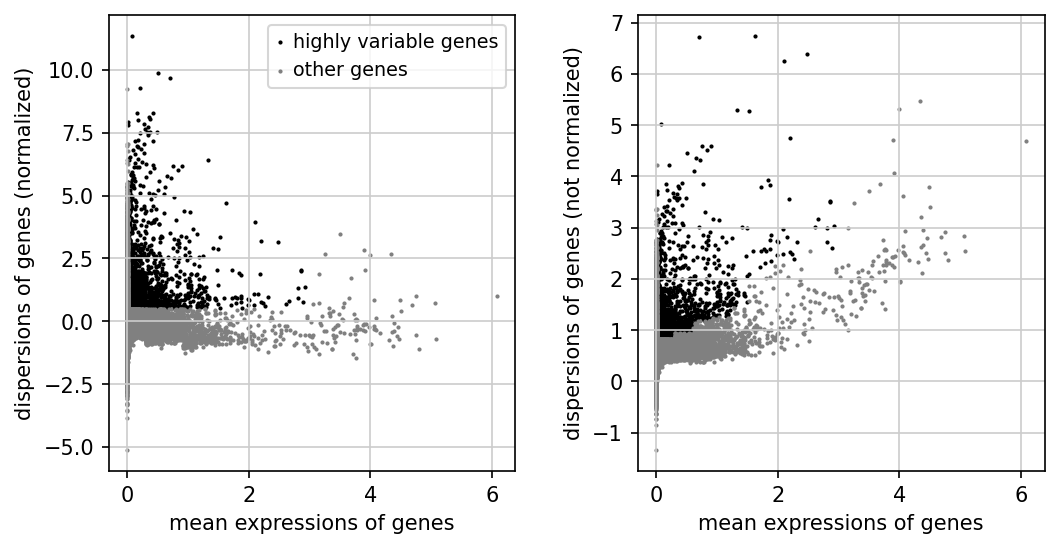

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:23)


In [34]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

### 1 PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


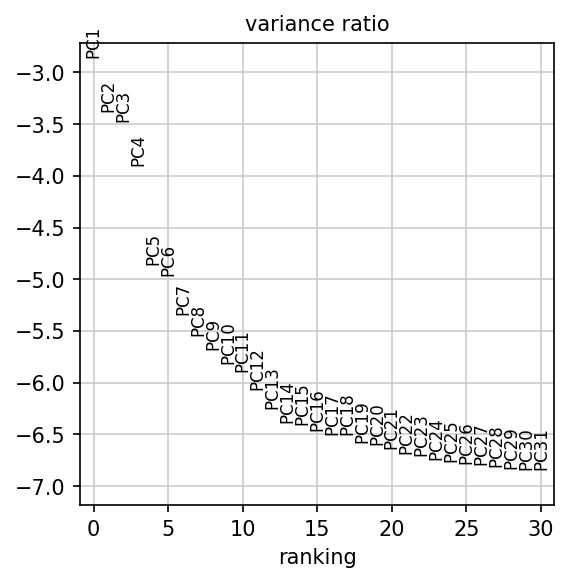

In [35]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

### 1b PCA component selection

In [36]:
# TODO

### 2 Visualization of highly variable genes

In [37]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


### 3 Clustering

In [38]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 5.3MB/s 


In [39]:
!pip install louvain

     |████████████████████████████████| 2.2MB 5.3MB/s 


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


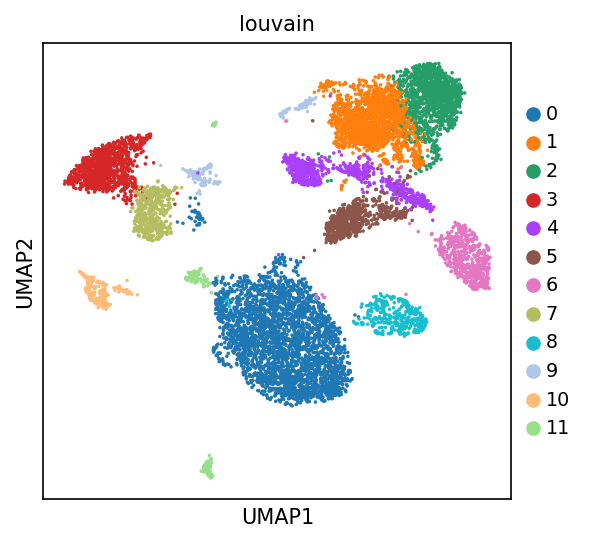

In [40]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


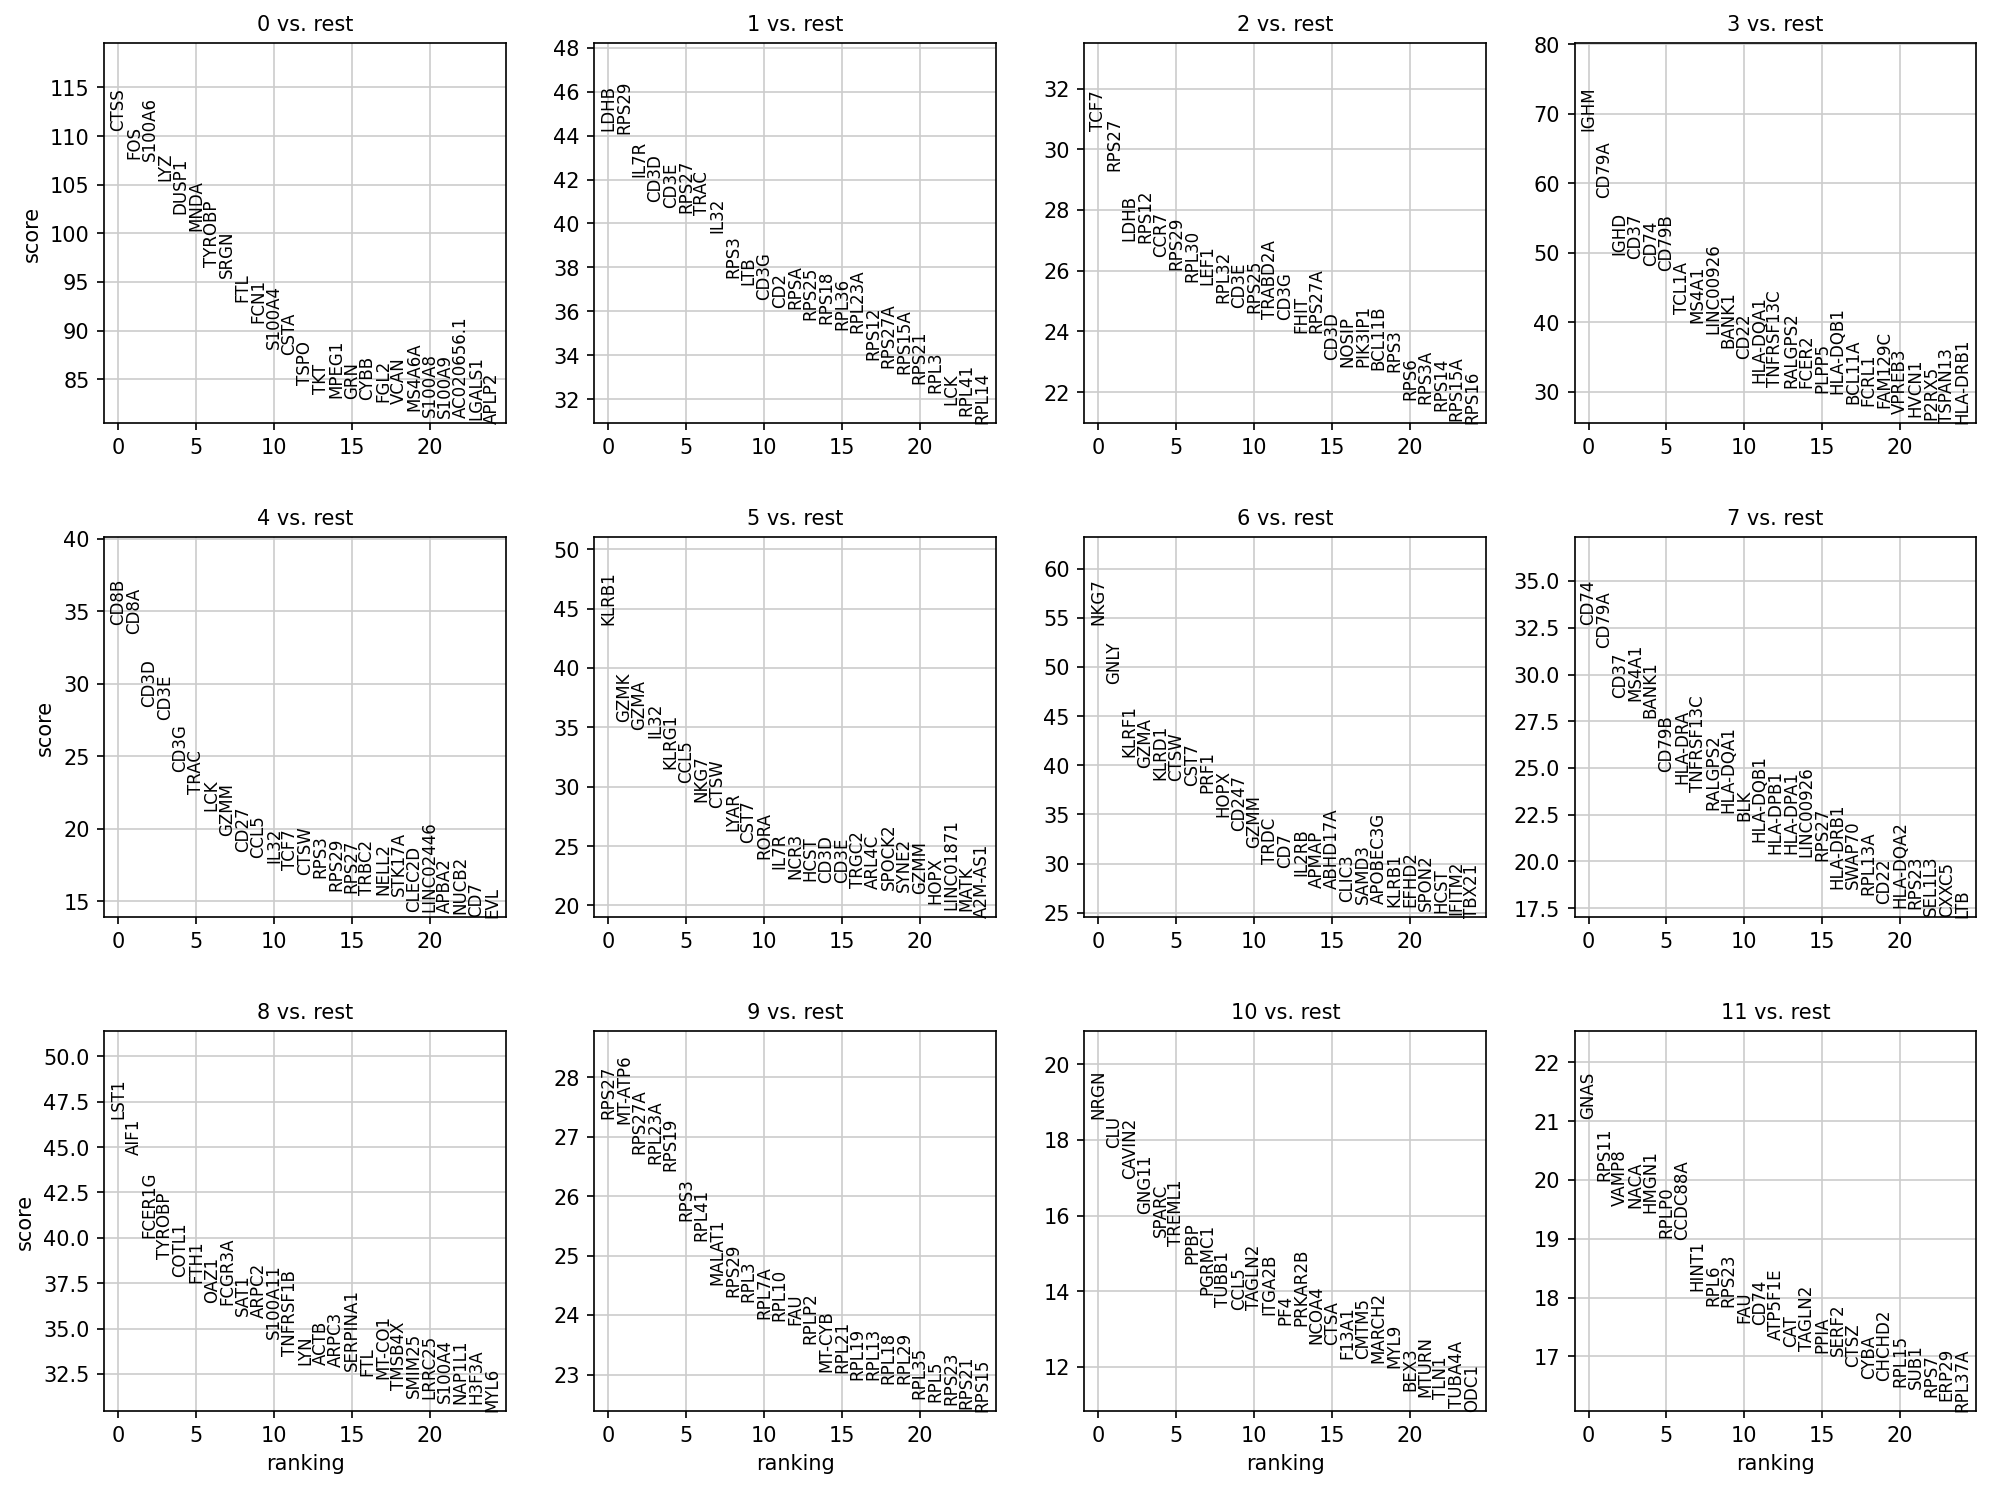

In [41]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

## SCENIC steps

In [ ]:
!pip install pyscenic
!pip install numba

In [54]:
!pip install bokeh

In [56]:
!pip install tbb

### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [49]:
# transcription factors list
f_tfs = "/content/drive/MyDrive/pySCENIC/resources/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [55]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)

2021-05-05 13:07:53,673 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-05-05 13:07:56,823 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/usr/local/lib/python3.7/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

failed to validate _ServerOpts(...).prefix: expected a value of type str, got None of type NoneType
  self.scheduler.start(scheduler_address)
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading lay

read in the adjacencies matrix:

In [51]:
adjacencies = pd.read_csv("/content/drive/MyDrive/pySCENIC/adj.csv", index_col=False, sep='\t')

EmptyDataError: ignored

In [ ]:
adjacencies.head()

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

locations for ranking databases, and motif annotations:

In [ ]:
import glob
# ranking databases
f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

### Visualization of SCENIC's AUC matrix

First, load the relevant data from the loom we just created

In [ ]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

## Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

Fix regulon objects to display properly in SCope:

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [ ]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

Assemble loom file row and column attributes

In [ ]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [ ]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Create a new loom file, copying the expression matrix from the open loom connection:

In [ ]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

This loom file can now be imported into [SCope](http://scope.aertslab.org/).